# Manual labelling of fault network

This tutorial shows how to label a fault network in a 2-D image by hand. This involves two steps:

**1. Labelling of polylines using labelme**

**2. Conversion of polylines to faults in a network**

## Labelling of polylines using labelme

First, we need to install labelme following the instructions on: https://github.com/wkentaro/labelme. Labelme is a graphical image annotation tool often used to label training data for machine learning. Here, we use it to map polylines (i.e. faults) in an image.

Once installed, we can simply call **labelme** in the console. This opens the following user interface:

![title](labelme/s1.png)

Now, we're opening the image that we want to label:

![title](labelme/s2.png)

Next, we can start labelling the image. Although we cannot label entire fault networks directly with labelme, we can label faults as polygons and combine them using the same group ID. To illustrate, we start labelling one fault as a polygon and assign it group ID: 0

![title](labelme/s3.png)

Now, we want to add a splay to this fault using the same group ID. To do this, we label another polygon and assign the same group ID: 0

![title](labelme/s4.png)

Next, we will combine these two polygons into a single structure in python. To export the polygons, we save the polygon as a .json file:

![title](labelme/s5.png)

## Conversion of polylines to faults in a network
We can load the polygons in python like this:

In [79]:
import json

# read file
with open('polygons.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

Next, we obtain all group IDs in the .json file

In [8]:
group_id = set()

shapes = obj['shapes']
for shape in shapes:
    group_id.add(shape['group_id'])

print(group_id)

{0, None}


Now, we can define an empty network and fill it with nodes and edges from the polygons of each group ID:

In [10]:
import networkx as nx

G = nx.Graph()

node = 0
for shape in shapes:    
    for group in group_id:                
        points = shape['points']        
        for m in range(len(points)):            
            position = (int(points[m][0]), int(points[m][1]))           
                
            G.add_node(node)
            G.nodes[node]['pos'] = position
    
            if m < len(points)-1:
                G.add_edge(node, node+1)                
            node += 1   

We can also plot the network like this:

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (24, 25), (26, 27)]


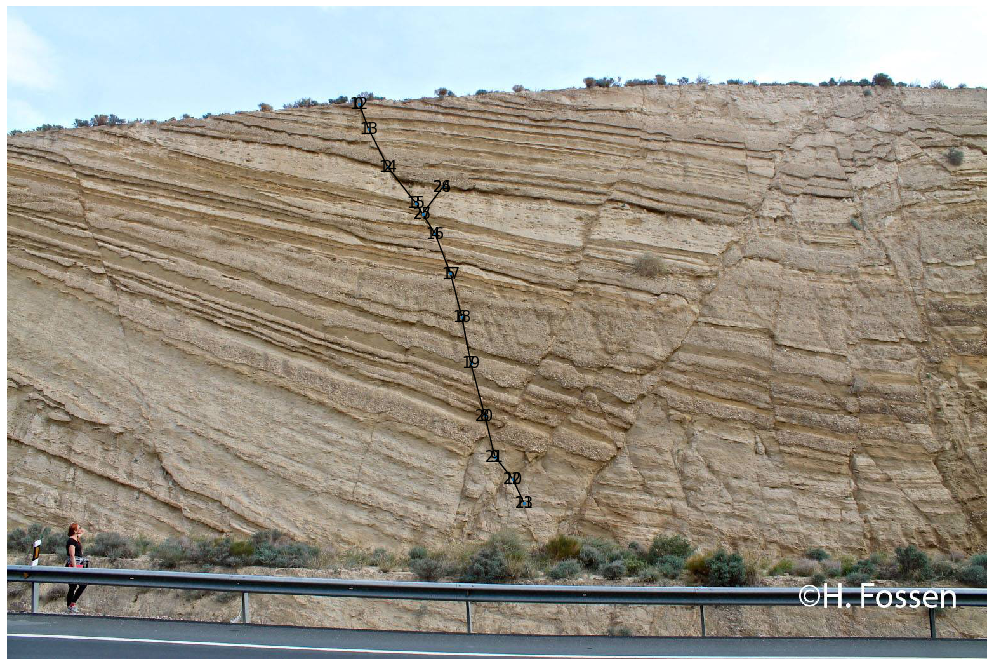

In [25]:
import matplotlib.pyplot as plt
from matplotlib.image import imread


img = imread('outcrop.jpg')


fig, axs = plt.subplots(1, 1, figsize=(20,12))
axs.imshow(img)


nx.draw(G,
        pos = nx.get_node_attributes(G, 'pos'),
        node_size = 5,
        with_labels = True,
        font_size = 15,
        ax = axs)

Although the network already looks fine, looking at the edges of the network more closely:

In [28]:
print(G.edges)

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (24, 25), (26, 27)]


we find that the nodes 15 and 25 are not connected, because they were part of different polygons. We can correct this by merging nodes within a certain distance threshold while preserving their edges:

In [41]:
import math

H = G.copy()

threshold = 25

for node in G:
    for another in G:
        
        if H.has_node(node) and H.has_node(another) and node != another:
        
        
            if math.sqrt((G.nodes[node]['pos'][0] - G.nodes[another]['pos'][0])**2  + 
                         (G.nodes[node]['pos'][1] - G.nodes[another]['pos'][1])**2) < threshold:
                
                neighbors = H.neighbors(another)
                
                for neighbor in neighbors:
                    H.add_edge(node, neighbor)
                
                H.remove_node(another)

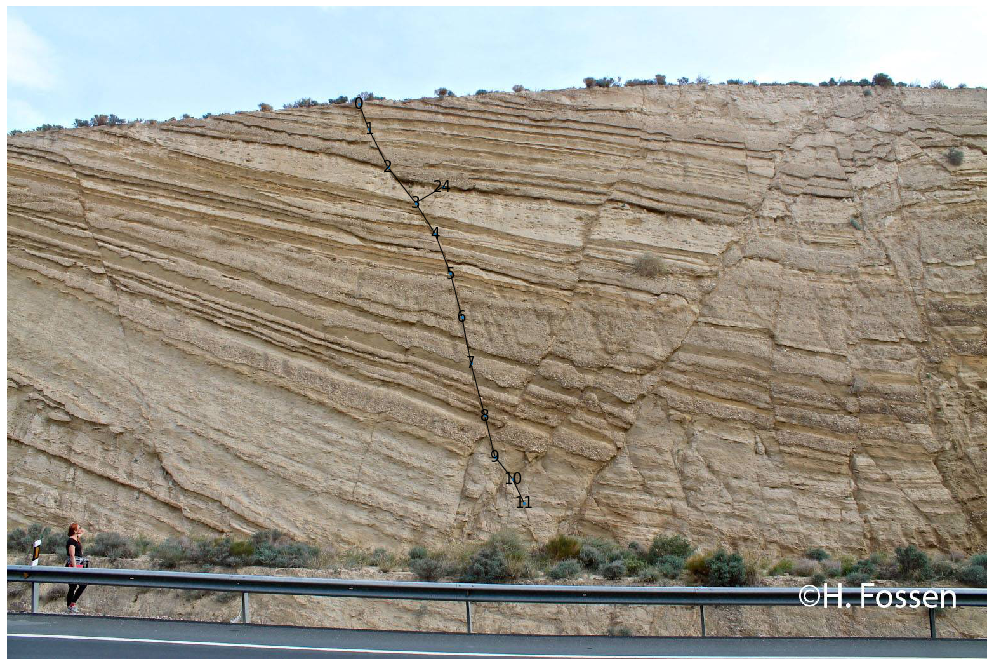

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(20,12))

axs.imshow(img)

nx.draw(H,
        pos = nx.get_node_attributes(G, 'pos'),
        node_size = 5,
        with_labels = True,
        font_size = 15,
        ax = axs)

Looking at the edges of the network:

In [43]:
print(H.edges)

[(0, 1), (1, 2), (2, 3), (3, 4), (3, 24), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11)]


shows an edge between node 3 and node 24.

# Application

Now, we can use this method to map all faults in the image. First, we label all polygons in labelme:

![title](labelme/s6.png)

Then, we save the .json file and load it in python:

In [95]:
import json

# read file
with open('polygons_all.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

We obtain the group IDs:

In [96]:
group_id = set()

shapes = obj['shapes']
for shape in shapes:
    group_id.add(shape['group_id'])

and build the network:

In [97]:
import networkx as nx

G = nx.Graph()

node = 0
for shape in shapes:    
    for group in group_id:                
        points = shape['points']        
        for m in range(len(points)):            
            position = (int(points[m][0]), int(points[m][1]))           
                
            G.add_node(node)
            G.nodes[node]['pos'] = position
    
            if m < len(points)-1:
                G.add_edge(node, node+1)                
            node += 1   

In [98]:
import math

H = G.copy()

threshold = 10

for node in G:
    for another in G:
        
        if H.has_node(node) and H.has_node(another) and node != another:
        
        
            if math.sqrt((G.nodes[node]['pos'][0] - G.nodes[another]['pos'][0])**2  + 
                         (G.nodes[node]['pos'][1] - G.nodes[another]['pos'][1])**2) < threshold:
                
                neighbors = H.neighbors(another)
                
                for neighbor in neighbors:
                    H.add_edge(node, neighbor)
                
                H.remove_node(another)

Now, we label the components (faults) in the network:

In [99]:
for label, cc in enumerate(sorted(nx.connected_components(H))): 
    for n in cc:
        H.nodes[n]['component'] = label

and generate palette of colors for the labels:

In [102]:
import numpy as np
import seaborn as sns

n_comp = 100

palette = sns.color_palette(None, 2*n_comp)

node_color = np.zeros((len(H),3))

for n, node in enumerate(H):
    color = palette[H.nodes[node]['component']]

    node_color[n,0] = color[0]
    node_color[n,1] = color[1]
    node_color[n,2] = color[2] 

Finally, we can plot our fault network:

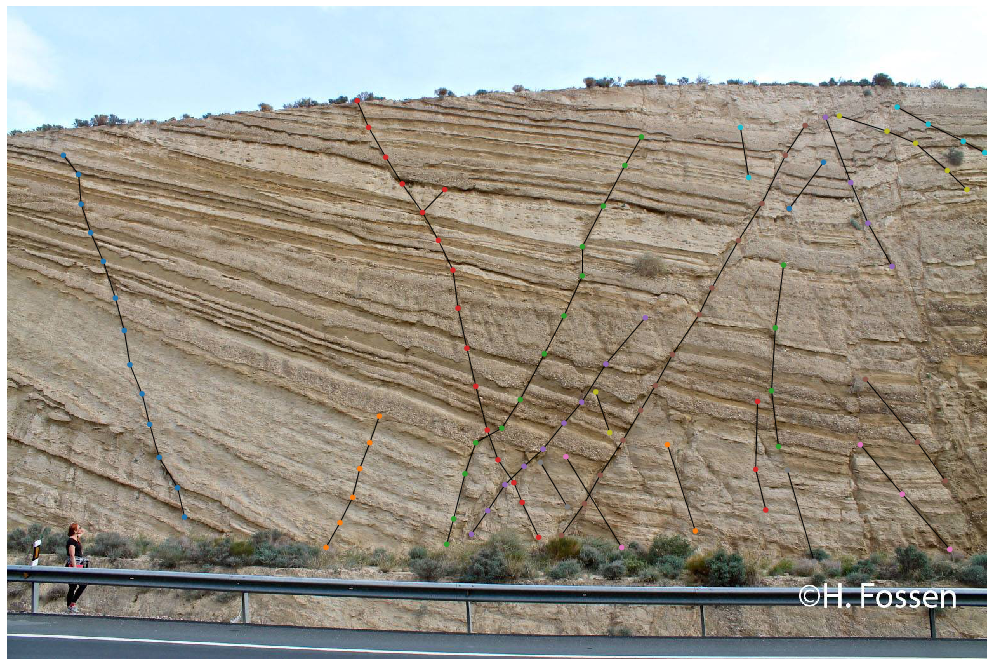

In [101]:
fig, axs = plt.subplots(1, 1, figsize=(20,12))

axs.imshow(img)

nx.draw(H,
        pos = nx.get_node_attributes(G, 'pos'),
        node_size = 20,
        node_color = node_color,
        with_labels = False,
        font_size = 15,
        ax = axs)